# 미니 프로젝트: 시계열 분류

- 미니프로젝트의 목표!  
    1. 비정상 데이터를 정상 데이터로 만들기
    2. 강의에 활용되었던 분류 모델의 성능을 높이기


- 용어 설명
    - 정규 분포(Normal distribution) : 확률 분포의 한 종류로, 대칭인 종모양의 형태를 지니고 있다.
        - 평균과 중앙값이 같으며 분포의 중앙에 있다. 
        - 데이터의 분포를 근사하는데 사용할 수 있다.
    - 로그함수(Log function) : 지수함수의 역함수
        - 지수함수 : $y = a^x$ 의 형태로 거듭제곱으로 증가하는 함수
        - 로그함수 : $y = log_a X$
    - 왜도(Skewness) : 분포가 정규분포에 비해서 얾마나 비대칭인지 나타내는 척도
        - 양(+)의 값을 가지면, Data의 중심(평균)이 정규 분포보다 왼쪽으로 치우쳐져 있고, 꼬리는 오른쪽으로 길어지게 표현된다.
        - 정규분포는 종모양의 대칭인 형태를 보이며 왜도는 0 이다.
    - 첨도(Kurtosis) : 종모양의 대칭인 정규 분포에서 중앙부분이 높아지거나 낮아지는 형태에 대한 통계량
        - 확률분포의 꼬리가두꺼운 정도를 나타내는 척도이며 극단적인 편차 또는 이상치가 많을 수록 큰 값을 나타낸다.
    - 배깅(bagging) :합습 데이터셋에서 샘픙르 랜덤하게 추출하여 하나의 모델을 학습
        - 부트스트랩(Boostrap) : 샘플을 여러개 추출한 것
        - Aggregration : 부트스트랩을 각 모델에 학습시켜서 나온 결과값을 합친 것
    - 부스팅(boosting) : 여러개의 결정 트리가 각각 예측한 값을 합쳐서 최종 결과값을 예측하는 방식
    - 앙상블(ensemble) : 하나의 강력한 모델이 아닌 약한 모델 여러 개를 합쳐서 사용하는 방식
    - RandomForest : 결정트리에서 Overfitting을 보완하기 위해 Bagging 방식을 적용한 것
    - XGBoost : Boosting 방식으로 적용한 Gradient Boost 모델
    - 특성 중요도(Featue importance): feature들 중에서 정답에 영향을 미치는 중요한 feature를 확인할 수 있는 기능

## 비정상 데이터를 정상 데이터로 만들기

### tsfresh 설치

In [1]:
!pip install tsfresh

In [ ]:
# 라이브러리 버전 충돌을 피하기 위해 런타임을 재시작합니다.
import os
os.kill(os.getpid(), 9)

### 필요한 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 데이터 불러오기

In [2]:
ap = pd.read_csv('AirPassengers.csv')
ap.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


#### Month 칼럼 삭제

In [3]:
ap.drop(columns='Month', inplace=True)
ap.head()

,#Passengers
0,112
1,118
2,132
3,129
4,121


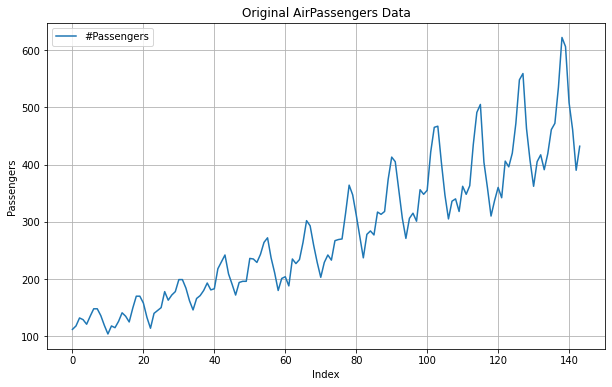

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(ap)
plt.title('Original AirPassengers Data')
plt.xlabel('Index')
plt.ylabel('Passengers')
plt.legend(ap.columns)
plt.grid(True)
plt.show()

## 비정상 데이터 확인

### 단위근 검정

In [61]:
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf

adf_result = adfuller(ap)
print('ADF Test Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Test Statistic: 0.8153688792060498
p-value: 0.991880243437641


- 해석
    - p-값이 0.991880243437641
        - 0.05보다 크므로 시계열 데이터 ap에 단위근이 존재한다고 결론지을 수 있다.
    - 즉, 시계열 데이터 ap의 값은 시간에 따라 일정한 패턴 없이 변동하고 있으며, 예측하기 어려울 수 있다.

- 추가적인 분석
    - 단위근을 제거하기 위해 차분 (differencing)과 같은 방법을 사용할 수 있다.
        - 차분: 시계열 데이터의 현재 값에서 이전 값을 뺀 값을 사용하는 방법
    - 차분을 적용한 후 다시 ADF 검정을 수행하여 단위근이 제거되었는지 확인할 수 있다.

### KPSS 검정

In [62]:
kpss_result = kpss(ap)
print('KPSS Test Statistic:', kpss_result[0])
print('p-value:', kpss_result[1])

KPSS Test Statistic: 1.6513122354165206
p-value: 0.01


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1998: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


- 해석
    - KPSS 검정: 시계열 데이터가 정상 과정 (stationary process)인지 검정하는 통계 검정 방법
    - p-value 유의수준 (일반적으로 0.05)보다 작으면 시계열 데이터가 정상 과정이 아니다고 판단할 수 있다.

- 이 경우의 해석:
    - p-value: 0.01
        - 0.05보다 작으므로 시계열 데이터 ap이 정상 과정이 아니다고 결론지을 수 있다.
        - 즉, 시계열 데이터 ap에는 단위근이나 추세, 계절성 등의 비정상성이 존재할 수 있다.

### 자기상관 검정

In [74]:
acf_result = acf(ap)
pacf_result = pacf(ap)

print(f'ACF(AutoCorrelation Function) : {acf_result}')
print(f'PACF(Partial AutoCorrelation Function) : {pacf_result}')

ACF(AutoCorrelation Function) : [1.         0.94804734 0.87557484 0.80668116 0.75262542 0.71376997
 0.6817336  0.66290439 0.65561048 0.67094833 0.70271992 0.74324019
 0.76039504 0.71266087 0.64634228 0.58592342 0.53795519 0.49974753
 0.46873401 0.44987066 0.4416288  0.45722376]
PACF(Partial AutoCorrelation Function) : [ 1.          0.95467704 -0.26527732  0.05546955  0.10885622  0.08112579
  0.00412541  0.15616955  0.10370833  0.28878144  0.20691805  0.2411297
 -0.15800498 -0.7183246  -0.08948064  0.22160591  0.13462253  0.11561572
  0.1948294   0.09665618 -0.20215868 -0.0936381 ]


- ACF(Autocorrelation Function)
    - ACF 결과: 시계열 데이터의 현재 값과 이전 값 간의 상관 관계
    - 출력된 값들은 지연 (lag)에 따른 상관 계수
        - 예를 들어 ACF[1]은 현재 값과 1개 이전 값 간의 상관 계수
    - 일반적으로 지연이 늘어날수록 상관 계수는 0에 가까워지는 것이 일반적

- PACF(Partial Autocorrelation Function)
    - PACF 결과: 현재 값과 이전 값 간의 직접적인 상관 관계
        - 이전 값들의 영향을 제외하고 현재 값과 이전 특정 값 간의 상관 관계를 보여준다.
    - ACF 결과와 비교하여 **유의미한 상관 관계가 지속되는 지연 (lag)**을 확인하는 데 도움이 된다.

- 해석
    - ACF 결과에서 첫 번째 지연 (lag 1) : 0.948
        - 높은 상관 계수를 관찰할 수 있다. 
            - 이는 현재 값과 1개 이전 값 사이에 강한 양의 상관 관계가 있음을 의미한다.
        - 지연이 증가할수록 상관 계수는 감소하지만 여전히 유의미한 값 (0.5 이상) 을 유지한다.
    - PACF 결과에서도 첫 번째 지연 (lag 1) : 0.955
        - 높은 상관 계수를 관찰할 수 있다. 
        - 두 번째 지연 (lag 2) 에서도 유의미한 상관 계수 (-0.265) 를 보인다.

- 결론
    - 시계열 데이터 ap에는 자기상관이 존재한다. 
        즉, 현재 값은 이전 값들과 상관 관계가 있다.
    - 특히 현재 값은 1개 이전 값과 가장 강한 양의 상관 관계를 가지며, 지연이 늘어나더라도 어느 정도의 상관 관계가 지속된다.

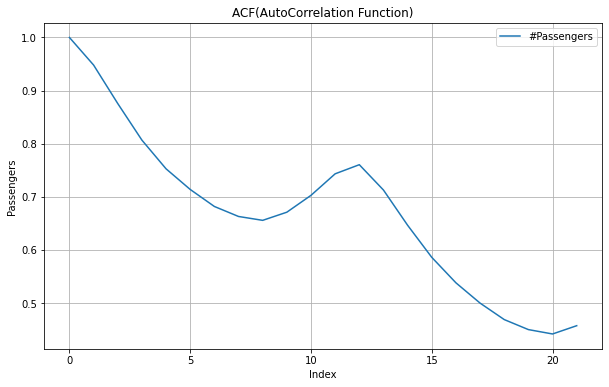

In [75]:
plt.figure(figsize=(10, 6))
plt.plot(acf_result)
plt.title('ACF(AutoCorrelation Function)')
plt.xlabel('Index')
plt.ylabel('Passengers')
plt.legend(ap.columns)
plt.grid(True)
plt.show()

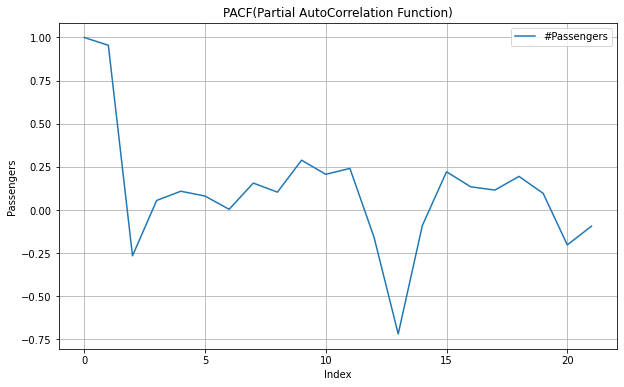

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(pacf_result)
plt.title('PACF(Partial AutoCorrelation Function)')
plt.xlabel('Index')
plt.ylabel('Passengers')
plt.legend(ap.columns)
plt.grid(True)
plt.show()

## 분산을 일정하게 만들기 - log transformation
- log transformation 하는 이유
    - 큰 수를 같은 비율의 작운 수로 만들 수 있다.
    - 복잡한 계산을 쉽게 만든다.
    - 왜도와 첨도를 줄여서 분석 시 의미있는 결과를 도출하기 위함이다.

### np.log를 통해 log transformation

In [5]:
log_transformed = np.log(ap)
log_transformed.head()

,#Passengers
0,4.718499
1,4.770685
2,4.882802
3,4.859812
4,4.795791


- 분산이 일정해진 것을 눈으로 확인할 수 있다.

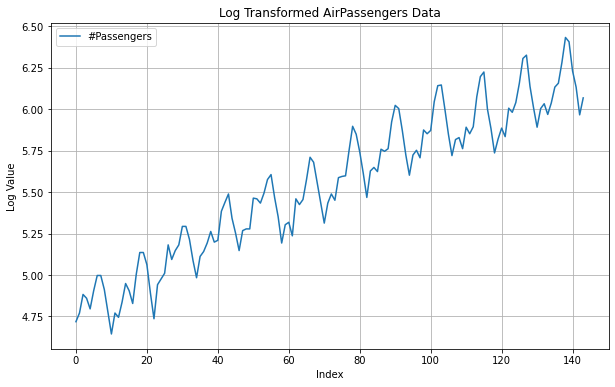

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(log_transformed)
plt.title('Log Transformed AirPassengers Data')
plt.xlabel('Index')
plt.ylabel('Log Value')
plt.legend(log_transformed.columns)
plt.grid(True)
plt.show()

## 차분을 통해 추세 제거하기

### diff()

- diff()
    - 시계열 데이터의 차분 (differencing)을 계산하는 함수
        - 차분: 시계열 데이터의 변화량을 계산하여 데이터를 정상 과정 (stationary process)에 가깝게 만드는 데 사용
        - 정상 과정:시간에 따라 평균과 분산이 변하지 않는 시계열 데이터
- parameter
    - series: 차분을 계산할 시계열 데이터
    - periods: 차분을 계산할 기간(default=1)
    - axis: 차분을 계산할 축(default=0)
- 작동 방식:
    - diff() 함수는 시계열 데이터의 현재 값에서 이전 값을 뺀 값을 차분으로 계산
        - 예를 들어, periods=1 인 경우 다음과 같이 계산
            - diff_series = series[1:] - series[:-1]
        - periods 값을 증가시키면 더 높은 차분을 계산할 수 있다.

In [7]:
diffed = ap.diff()
diffed.head()

,#Passengers
0,NaN
1,6.0
2,14.0
3,-3.0
4,-8.0


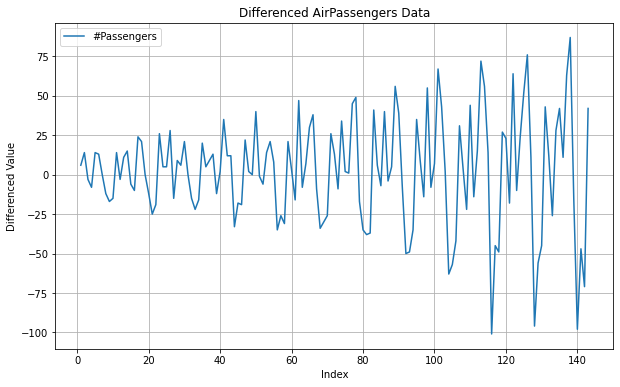

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(diffed)
plt.title('Differenced AirPassengers Data')
plt.xlabel('Index')
plt.ylabel('Differenced Value')
plt.legend(diffed.columns)
plt.grid(True)
plt.show()

### 계절 차분을 통해 계절성 제거하기
AirPassengers 데이터는 12개월을 주기로하는 계절성이 포함되어 있다.  
이런 경우엔 겨젤 차분을 통해서 계절성을 데이터에서 제거할 수 있다.

- diff에 12라는 값을 넣어주면 주기를 12로 하는 계절 차분을 수행할 수 있다

In [9]:
seasonally_diffed = diffed.diff(12)
seasonally_diffed.head()

,#Passengers
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


- 차분을 하면 데이터가 짧아지기 때문에 빈칸을 제거해야 한다.

In [10]:
seasonally_diffed.dropna(inplace=True)
seasonally_diffed

,#Passengers
13,5.0
14,1.0
15,-3.0
16,-2.0
17,10.0
...,...
139,-27.0
140,-2.0
141,9.0
142,-26.0


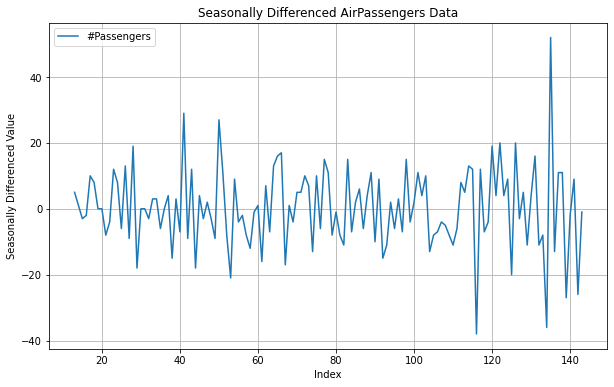

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(seasonally_diffed)
plt.title('Seasonally Differenced AirPassengers Data')
plt.xlabel('Index')
plt.ylabel('Seasonally Differenced Value')
plt.legend(seasonally_diffed.columns)
plt.grid(True)
plt.show()

## 검정을 통해 정상성 확인하기

- adfuller : Python에서 statsmodels을 통해 ADF(Augmented Dickey-Fuller) Test를 할 수 있다. 
    - 앞서 Classification report를 통해 Logistic Regression 모델을 검증한 것과 마찬가지로 시계열 데이터를 통계 분석하고 검증할 때 사용한다. 
    - adfuller를 사용하면 대표적으로 다음과 같은 값을 얻을 수 있다.
        - adf(단위근 검정, Augmented Dickey Fuller) : 정상성을 확인하기 위한 단위근 검정방법
        - p-value(유의 검정) : 관찰된 데이터가 귀무가설이 맞다면 통계값 1이 실제로 관측된 값 이상일 확률
        - usedlag : 사용된 시차의 수
        - nobs : ADF 회귀 및 임계값 계산에 사용된 관측치의 수   
        - critical values(임계값) : 1%, 5% 및 10% 수준에서 테스트 통계에 대한 임계값
        - icbest : 0, 1, …, maxlag 값 중 lag 길이를 자동으로 결정할 때 autolag를 사용하며 이때 autolag를 none으로 지정할 수 있는데 none으로 지정하지 않는 경우 최대화된 정보 기준





### adf검정을 위한 함수 정의

In [76]:
def adf_test(x):
    stat, p_value, lags, nobs, crit, icb = adfuller(x)  # adfuller 함수를 이용하면 6가지 output이 나온다.
    print('ADF statistics')
    print(stat)                                         # ADF 검정 통계량
    print('P-value')
    print(p_value)                                      # P-value

### adf 테스트 수행

In [77]:
adf_test(seasonally_diffed)

ADF statistics
-15.595618083746338
P-value
1.856511600123444e-28


- 해석
    - 이전 단계에서 시계열 데이터 ap에 단위근이 존재한다는 결론을 얻었다.
    - 계절 차분을 적용한 데이터 seasonally_diffed에 대해 ADF 검정을 수행한 결과,
        - ADF 검정 통계량: -15.5956
        - p-값은 1.8565e-28

- 이 경우의 해석
    - p-값이 0.05보다 매우 작으므로 시계열 데이터 seasonally_diffed에 단위근이 존재하지 않는다고 결론지을 수 있다.
        - 일반적으로 P-값이 작을수록 귀무가설을 기각하는 경향이 강하며, 따라서 시계열 데이터가 안정적인 시계열로 간주된다. 
        - 즉, 계절 차분을 통해 시계열 데이터의 단위근을 제거하는데 성공했다.
    - 차분된 데이터는 시간에 따라 일정한 패턴을 가지고 변동하며, 예측하기 용이해졌다.
- 결론
    - 계절 차분은 시계열 데이터 ap의 단위근 문제를 해결하는 데 효과적이었다.
    - 차분된 데이터 seasonally_diffed를 기반으로 시계열 분석을 진행할 수 있다.
        - 즉, 유의수준 0.01에서 단위근이 존재한다라는 귀무가설을 기각하고 시계열은 정상적이다라는 대립가설을 채택할 수 있다.

## 시계열 분류

TSFresh 라이브러리

- TSFresh
    - Python에서 시계열 데이터 분석을 위한 오픈 소스 라이브러리
    - TSFresh는 시계열 데이터에서 수백 가지 특징을 자동으로 추출하고 계산할 수 있다.
    - 추출된 특징은 머신 러닝 모델 학습에 사용될 수 니다.

- 주요 기능
    - 다양한 종류의 시계열 데이터 지원
    - 수백 가지 특징 자동 추출 및 계산
    - 특징 선택 및 변환 기능 제공
    - 시각화 기능 제공
    - 머신 러닝 모델 학습 및 평가 기능 제공

TSFresh 공식 문서: https://tsfresh.readthedocs.io/en/latest/  
TSFresh GitHub 저장소: https://github.com/blue-yonder/tsfresh

### 데이터 다운로드 및 불러오기

In [14]:
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures

# robot exection failures 데이터를 불러오기
download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

### 데이터셋 확인

- X 변수  
id, time을 제외하고 6개의 colums

In [15]:
timeseries

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0
...,...,...,...,...,...,...,...,...
1315,88,10,-10,2,39,-21,-24,5
1316,88,11,-11,2,38,-24,-22,6
1317,88,12,-12,3,23,-24,-24,5
1318,88,13,-13,4,26,-29,-27,5


- y 변수  
True/False

In [16]:
y

1      True
2      True
3      True
4      True
5      True
      ...  
84    False
85    False
86    False
87    False
88    False
Length: 88, dtype: bool

### 데이터셋 가공

In [17]:
def custom_classification_split(x, y, test_size):
    num_true = int(y.sum()*test_size)           # int(21 * 0.3) = 6
    num_false = int((len(y)-y.sum())*test_size) # int((88 - 21)*0.3) = 20

    id_list = y[y==False].head(num_false).index.to_list() + y[y==True].head(num_true).index.to_list()

    y_train = y.drop(id_list)                   # y에서 id_list를 drop
    y_test = y.iloc[id_list].sort_index()       # 20~39, 2~7이 합쳐진 리스트를 정렬
    X_train = x[~x['id'].isin(id_list)]         # 대괄호 안에 있는 timeseries의 id와 id_list가 일치하는 것만 사용하고 물결표시는 안에 조건이 포함되어 있지 않는것만 사용한다.
    X_test = x[x['id'].isin(id_list)]           # timeseries의 id와 id_list가 일치하는 것만 사용해서 timeseries에 적용

    return X_train, y_train, X_test, y_test

- `id_list`
    - y==False인것과 y==True인것의 인덱스값을 리스트로 변환하여 더해준다
    - y[y==False].head(num_false).index.to_list()는 19~38까지의 값이 리스트로
    - y[y==True].head(num_true).index.to_list()는 1~6까지의 값이 리스트로
    - id_list는 20~39 + 2~7이 더해진 리스트이다

### 데이터셋 나누기

In [18]:
X_train, y_train, X_test, y_test = custom_classification_split(timeseries, y, test_size=0.25)

In [19]:
print(f'X train shape : {X_train.shape}')
print(f'y train shape : {y_train.shape}')
print(f'X test shape : {X_test.shape}')
print(f'y test shape : {y_test.shape}')

X train shape : (1005, 8)
y train shape : (67,)
X test shape : (315, 8)
y test shape : (21,)


In [20]:
print(X_train)
print('-'*50)
print(y_train)
print('-'*50)
print(X_test)
print('-'*50)
print(y_test)

      id  time  F_x  F_y  F_z  T_x  T_y  T_z
75     6     0   -1    2   57  -10   -3    0
76     6     1   -2    3   60  -12   -4   -1
77     6     2   -1    2   63  -12   -6    1
78     6     3    1    3   62  -11    0    0
79     6     4   -3    2   56   -9   -4    0
...   ..   ...  ...  ...  ...  ...  ...  ...
1315  88    10  -10    2   39  -21  -24    5
1316  88    11  -11    2   38  -24  -22    6
1317  88    12  -12    3   23  -24  -24    5
1318  88    13  -13    4   26  -29  -27    5
1319  88    14  -13    2   15  -25  -25    6

[1005 rows x 8 columns]
--------------------------------------------------
6      True
7      True
8      True
9      True
10     True
      ...  
84    False
85    False
86    False
87    False
88    False
Length: 67, dtype: bool
--------------------------------------------------
     id  time  F_x  F_y  F_z  T_x  T_y  T_z
0     1     0   -1   -1   63   -3   -1    0
1     1     1    0    0   62   -3   -1    0
2     1     2   -1   -1   61   -3    0    0
3

### feature extraction

EfficientParameters: 큰 계산비용이 필요한 calculator를 제외하고 가능한 모든 특징을 생성

In [21]:
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute

settings = EfficientFCParameters()

In [22]:
comprehensive_features_train = extract_features(X_train, 
                                                column_id="id",
                                                column_sort="time",
                                                default_fc_parameters=settings)

Feature Extraction: 100%|██████████| 402/402 [00:17<00:00, 22.52it/s]


In [23]:
comprehensive_features_train.columns

Index(['F_x__variance_larger_than_standard_deviation',
       'F_x__has_duplicate_max', 'F_x__has_duplicate_min',
       'F_x__has_duplicate', 'F_x__sum_values', 'F_x__abs_energy',
       'F_x__mean_abs_change', 'F_x__mean_change',
       'F_x__mean_second_derivative_central', 'F_x__median',
       ...
       'T_z__fourier_entropy__bins_5', 'T_z__fourier_entropy__bins_10',
       'T_z__fourier_entropy__bins_100',
       'T_z__permutation_entropy__dimension_3__tau_1',
       'T_z__permutation_entropy__dimension_4__tau_1',
       'T_z__permutation_entropy__dimension_5__tau_1',
       'T_z__permutation_entropy__dimension_6__tau_1',
       'T_z__permutation_entropy__dimension_7__tau_1',
       'T_z__query_similarity_count__query_None__threshold_0.0',
       'T_z__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=4662)

In [24]:
comprehensive_features_test = extract_features(X_test, 
                                               column_id="id",
                                               column_sort="time",
                                               default_fc_parameters=settings)

Feature Extraction: 100%|██████████| 126/126 [00:05<00:00, 22.85it/s]


In [25]:
comprehensive_features_test.columns

Index(['F_x__variance_larger_than_standard_deviation',
       'F_x__has_duplicate_max', 'F_x__has_duplicate_min',
       'F_x__has_duplicate', 'F_x__sum_values', 'F_x__abs_energy',
       'F_x__mean_abs_change', 'F_x__mean_change',
       'F_x__mean_second_derivative_central', 'F_x__median',
       ...
       'T_z__fourier_entropy__bins_5', 'T_z__fourier_entropy__bins_10',
       'T_z__fourier_entropy__bins_100',
       'T_z__permutation_entropy__dimension_3__tau_1',
       'T_z__permutation_entropy__dimension_4__tau_1',
       'T_z__permutation_entropy__dimension_5__tau_1',
       'T_z__permutation_entropy__dimension_6__tau_1',
       'T_z__permutation_entropy__dimension_7__tau_1',
       'T_z__query_similarity_count__query_None__threshold_0.0',
       'T_z__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=4662)

### impute

간단히 데이터를 전처리

In [26]:
impute(comprehensive_features_train)

/opt/conda/lib/python3.9/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
6,1.0,1.0,1.0,1.0,-15.0,39.0,1.714286,0.142857,0.153846,-1.0,...,0.974315,1.213008,1.732868,1.438883,1.863680,2.145842,2.163956,2.197225,0.0,0.714286
7,0.0,1.0,0.0,1.0,-13.0,21.0,0.928571,0.214286,-0.076923,-1.0,...,1.255482,1.494175,2.079442,1.043794,1.349792,1.666333,1.748067,1.831020,0.0,0.428571
8,1.0,0.0,1.0,1.0,-10.0,26.0,1.142857,-0.142857,0.192308,-1.0,...,1.494175,1.732868,2.079442,1.412745,2.138333,2.397895,2.302585,2.197225,0.0,1.285714
9,1.0,0.0,0.0,1.0,-10.0,24.0,1.428571,0.000000,-0.076923,-1.0,...,1.255482,1.494175,2.079442,1.479133,2.138333,2.397895,2.302585,2.197225,0.0,1.285714
10,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,0.000000,-1.0,...,0.937285,1.213008,1.906155,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,1.0,1.0,0.0,1.0,-1073.0,96833.0,7.142857,-5.428571,-0.038462,-98.0,...,0.735622,0.735622,1.386294,1.585771,2.253858,2.397895,2.302585,2.197225,0.0,24.285714
85,1.0,0.0,1.0,1.0,143.0,1683.0,1.357143,1.071429,0.076923,8.0,...,0.735622,0.735622,1.667462,1.332245,1.589027,1.893788,2.163956,2.197225,0.0,5.571429
86,1.0,0.0,0.0,0.0,961.0,83497.0,9.071429,9.071429,0.807692,52.0,...,0.735622,1.073543,1.732868,0.687092,0.983088,1.159589,1.227529,1.303092,0.0,9.285714
87,1.0,1.0,0.0,1.0,4509.0,1405437.0,12.928571,12.214286,-1.038462,338.0,...,0.735622,0.735622,1.386294,0.535961,0.836988,1.159589,1.497866,1.581094,0.0,40.285714


In [27]:
impute(comprehensive_features_test)

/opt/conda/lib/python3.9/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,-0.038462,-1.0,...,1.073543,1.440235,2.079442,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.000000
2,0.0,1.0,1.0,1.0,-13.0,25.0,1.000000,0.000000,-0.038462,-1.0,...,1.073543,1.494175,2.079442,0.937156,1.234268,1.540306,1.748067,1.831020,0.0,0.571429
3,0.0,0.0,1.0,1.0,-10.0,12.0,0.714286,0.000000,-0.038462,-1.0,...,1.386294,1.732868,2.079442,1.265857,1.704551,2.019815,2.163956,2.197225,0.0,0.571429
4,0.0,1.0,1.0,1.0,-6.0,16.0,1.214286,-0.071429,-0.038462,0.0,...,1.073543,1.494175,2.079442,1.156988,1.907284,2.397895,2.302585,2.197225,0.0,1.000000
5,0.0,0.0,0.0,1.0,-9.0,17.0,0.928571,-0.071429,0.038462,-1.0,...,0.900256,1.320888,2.079442,1.156988,1.863680,2.271869,2.302585,2.197225,0.0,0.857143
19,1.0,0.0,0.0,1.0,99.0,6109.0,13.928571,-1.928571,-1.730769,1.0,...,0.974315,1.494175,1.906155,1.230932,1.704551,2.019815,2.025326,2.043192,0.0,1.428571
20,1.0,0.0,1.0,1.0,155.0,34455.0,16.714286,-13.142857,7.576923,-1.0,...,1.386294,1.667462,2.079442,1.564957,2.022809,2.271869,2.302585,2.197225,0.0,2.571429
21,1.0,0.0,0.0,1.0,-171.0,16495.0,20.928571,1.785714,3.961538,-1.0,...,0.735622,0.735622,0.735622,1.303876,1.791759,2.271869,2.302585,2.197225,0.0,17.285714
22,1.0,0.0,0.0,1.0,102.0,12700.0,10.785714,-8.071429,4.500000,-1.0,...,0.562335,0.735622,1.732868,1.524707,2.138333,2.397895,2.302585,2.197225,0.0,5.428571
23,1.0,0.0,0.0,1.0,67.0,10593.0,15.142857,-7.000000,3.000000,-3.0,...,0.974315,1.255482,2.079442,1.519383,2.369382,2.397895,2.302585,2.197225,0.0,3.714286


### 모델 학습 및 결과 확인

#### Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression

# 모델 생성
lg = LogisticRegression()

# 모델 학습
lg.fit(comprehensive_features_train, y_train)

LogisticRegression()

In [29]:
# 결과
lg.score(comprehensive_features_test, y_test)

0.5714285714285714

- classification_report

In [32]:
lg_pred = lg.predict(comprehensive_features_test)

In [33]:
from sklearn.metrics import classification_report

print((classification_report(y_test, lg_pred, target_names=['true', 'false'])))

              precision    recall  f1-score   support

        true       1.00      0.44      0.61        16
       false       0.36      1.00      0.53         5

    accuracy                           0.57        21
   macro avg       0.68      0.72      0.57        21
weighted avg       0.85      0.57      0.59        21



In [34]:
classification_report(y_test, 
                      lg_pred, 
                      target_names = ['true', 'false'], 
                      output_dict = True)

{'true': {'precision': 1.0,
  'recall': 0.4375,
  'f1-score': 0.6086956521739131,
  'support': 16},
 'false': {'precision': 0.35714285714285715,
  'recall': 1.0,
  'f1-score': 0.5263157894736842,
  'support': 5},
 'accuracy': 0.5714285714285714,
 'macro avg': {'precision': 0.6785714285714286,
  'recall': 0.71875,
  'f1-score': 0.5675057208237986,
  'support': 21},
 'weighted avg': {'precision': 0.846938775510204,
  'recall': 0.5714285714285714,
  'f1-score': 0.5890813991500491,
  'support': 21}}

#### RandomForest 

In [47]:
from sklearn.ensemble import RandomForestClassifier

# 모델 생성
rf_clf = RandomForestClassifier(n_estimators=10, max_depth=3)

# 모델 학습
rf_clf.fit(comprehensive_features_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10)

In [48]:
# 결과
rf_clf.score(comprehensive_features_test, y_test)

0.9047619047619048

- classification_report

In [49]:
rf_pred = rf_clf.predict(comprehensive_features_test)

In [50]:
from sklearn.metrics import classification_report

print((classification_report(y_test, rf_pred, target_names=['true', 'false'])))

              precision    recall  f1-score   support

        true       1.00      0.88      0.93        16
       false       0.71      1.00      0.83         5

    accuracy                           0.90        21
   macro avg       0.86      0.94      0.88        21
weighted avg       0.93      0.90      0.91        21



In [51]:
classification_report(y_test, 
                      rf_clf.predict(comprehensive_features_test), 
                      target_names = ['true', 'false'], 
                      output_dict = True)

{'true': {'precision': 1.0,
  'recall': 0.875,
  'f1-score': 0.9333333333333333,
  'support': 16},
 'false': {'precision': 0.7142857142857143,
  'recall': 1.0,
  'f1-score': 0.8333333333333333,
  'support': 5},
 'accuracy': 0.9047619047619048,
 'macro avg': {'precision': 0.8571428571428572,
  'recall': 0.9375,
  'f1-score': 0.8833333333333333,
  'support': 21},
 'weighted avg': {'precision': 0.9319727891156463,
  'recall': 0.9047619047619048,
  'f1-score': 0.9095238095238096,
  'support': 21}}

#### XGBoost

In [52]:
from xgboost import XGBClassifier
import xgboost as xgb

# 모델 생성
xgb_clf = XGBClassifier(n_estimators=10, max_depth=3)

# 모델 학습
xgb_clf.fit(comprehensive_features_train, y_train)

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:17:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=2, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [53]:
# 결과
xgb_clf.score(comprehensive_features_test, y_test)

1.0

- XGBoost plot_importance 확인 및 시각화

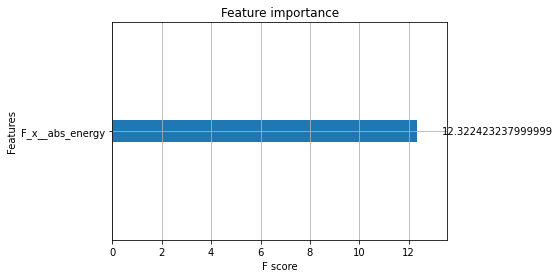

In [54]:
xgb.plot_importance(xgb_clf, importance_type='gain')
plt.show()

- Fx 값의 abs_energy 특징만의 유의미함  
고장 유무를 판별하는 기준은 F_X_abs_energy라는 특징 하나였다. 

In [55]:
sum(xgb_clf.feature_importances_ != 0)

1

### Classification report를 통한 검증 및 분석

In [56]:
xgb_pred = xgb_clf.predict(comprehensive_features_test)

In [57]:
from sklearn.metrics import classification_report

print((classification_report(y_test, xgb_pred, target_names=['true', 'false'])))

              precision    recall  f1-score   support

        true       1.00      1.00      1.00        16
       false       1.00      1.00      1.00         5

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



In [58]:
classification_report(y_test, 
                      xgb_pred, 
                      target_names=['true', 'false'], 
                      output_dict=True)

{'true': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 16},
 'false': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21}}

## 회고

시계열 데이터는 확실히 수학적으로 연관이 되어있는 거 같다보니까,,,
상당히 이해하는데 시간이 걸리는 거 같다.  

용어가 한번에 쏟아지니까 헷갈리기도 하고 이게 뭔가 싶어서 열심히 찾아보고  
코드 하나하나 뜯어보면서 설명 적으니까 시간이 금방 가는 거 같다.  

아직까지 봐야할 것도 많고 공부는 하면 할 수록 줄지 않는 거 같다.  
이러다 죽을때까지 공부하다 죽는 거 아닌가 싶기도 하고,,  
그렇게 맨날은 안하겠지만 양이 많다보니까 이런 생각도 드는 거 같다....ㅠ  

뭐,, 열심히 하는 거 말고는 방법이 없는 거 같긴 하다.  
힘내보자 화이팅~ !!